In [26]:
import numpy as np
import time
import discretize
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from pymatsolver import Pardiso as Solver
from SimPEG import maps, data
from SimPEG.meta import MultiprocessingMetaSimulation
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
from SimPEG.electromagnetics import natural_source as nsem
from discretize.utils import mkvc, ndgrid, active_from_xyz
from SimPEG.utils import plot2Ddata

Inverting real ZTEM dataset

Based on this GIFTools example: https://giftoolscookbook.readthedocs.io/en/latest/content/comprehensive_workflow/joint_mt_ztem/index.html

## Problem set up
Load data. 
The data used here is that avaialbe from the GIFTools example. The data file is organized by columns that correspond to 
`x, y, z, Tzx_real, Tzx_real_error, Tzx_imag, Tzx_imag_error, Tzy_real, Tzy_real_error, Tzy_imag, Tzy_imag_error`
The columns are seperated by a line header for each frequency. 

In the code below, the data is loaded into a list, the error columns are zero and are thus dropped, and the frequency is added as a column at the end. The data is finally loaded as a numpy array to be compatible with SimPEG.

The data array can then be used to create SimPEG `survey` and `data` objects.


Note that the data here is decimated due to computational constraints. 

In [27]:
# Load the topo
dir = "../data/field/"
topo = np.loadtxt(dir + "topo.xyz")

In [28]:
# Import data as a list and rearrange the data based on frequencies
data_by_freq = {}

with open(dir + "ztem_data.dat", 'r') as file:
    # Iterate over each line in the file
    for line in file:
        # If the line starts with "frequency", update the current frequency

        if line.startswith("FREQUENCY"):
            current_freq = int(line.split()[1])  # Assuming the frequency is an integer
            data_by_freq[current_freq] = []
            n_recv = int(next(file).split()[1])  # Get the number of rows for the current frequency
            for _ in range(n_recv):  # Read the next n_recv lines
                row = [float(x) for x in next(file).split()]
                row_without_zeros = [x for x in row if x != 0.0]  # Ignore columns with zeros
                row_without_zeros.append(current_freq)  # Add the frequency as a new column
                data_by_freq[current_freq].append(row_without_zeros)

# Convert list to array organized as (x,y,z, Tzx_real,Tzx_imag, Tzy_real,Tzy_imag, freq)
ztem_data = np.concatenate([np.array(data_by_freq[freq]) for freq in data_by_freq])


In [29]:
# #Decimate data to include every decimation-factor point
decimation_factor = 0.0011
decimation_index = int(n_recv*decimation_factor)
print(f"Decimating by {decimation_factor*100}% or every {decimation_index}th data point")
ztem_data_deci = ztem_data[::decimation_index]
topo_deci = topo[::decimation_index]

Decimating by 0.11% or every 10th data point


(5901,)

(984, 3)


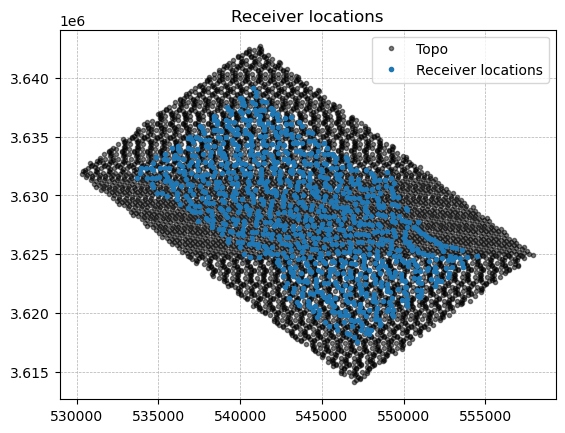

In [30]:
#rx_subset = ztem_data_deci[ztem_data_deci[:,-1] == ztem_data_deci[:,-1][9]]
def rx_locs(data, freq):
    rx_subset = data[data[:,-1] == freq]
    rx_x = rx_subset[:, 0]
    rx_y = rx_subset[:, 1]
    rx_z = rx_subset[:, 2]
    receiver_locations = np.c_[rx_x,rx_y,rx_z]
    return receiver_locations
receiver_locations = rx_locs(ztem_data_deci, 30)
print(receiver_locations.shape)
plt.plot(topo_deci[:, 0], topo_deci[:, 1],'k.',alpha=0.5,label='Topo')
plt.plot(receiver_locations[:, 0], receiver_locations[:, 1],'.',label='Receiver locations')
plt.title('Receiver locations')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

## Mesh Design
For FDEM data, the mesh extent should be informed by the skin depth of the lowest and highest frequencies. The skin depth is given by:

\begin{equation}
\delta \approx 500\sqrt{\frac{1}{\sigma {f}}}
\end{equation}

For ZTEM the lowest frequency is 30 Hz and highest is 720 Hz.
So assuming the background conductivity of 0.01 S/m,
skin depth for the highest frequency is 188 m and for the lowest frequency is 918 m.

The minimum cell size must be smaller than the minimum skin depth (typically 1/3 times), and the mesh size should extend to at least 2-3 times the maximum skin depths from the Tx.

Here, the values for base cell width are chosen to be finer than receommended to be consistent with the GIFTools example. 

For faster results, consider comment out the refine around receiver as natural source EM fields are smoother tham controlled source and as such refining around receivers is not as important here.

In [57]:
# compute skin depth
def skin_depth(freq, cond_back):
    return 500*np.sqrt(1/(cond_back*freq))  

frequencies = np.r_[30, 45, 90, 180, 360, 720] 

print(f"Max skin depth at {np.min(frequencies)} Hz: {skin_depth(np.min(frequencies), 1e-3)} m")
print(f"Min skin depth at {np.max(frequencies)} Hz: {skin_depth(np.max(frequencies), 1e-3)} m")

Max skin depth at 30 Hz: 2886.7513459481293 m
Min skin depth at 720 Hz: 589.2556509887896 m


In [115]:
# domain OcTree mesh

dh = 150.0  # base cell width
dhz = 80.0  # base cell width for z axis
dom_width_x = 40000.0  # domain width x
dom_width_y = 40000.0  # domain width y
dom_width_z = 6000.0  # domain width z

# Number of base mesh cells in each direction. Must be a power of 2
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcy = 2 ** int(np.round(np.log(dom_width_y / dh) / np.log(2.0)))  # num. base cells y
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hy = [(dh, nbcy)]
hz = [(dh, nbcz)]

x0 = np.median(receiver_locations[:,0])
y0 = np.median(receiver_locations[:,1])
z0 = np.median(receiver_locations[:,2])

origin = [x0-dom_width_x/2, y0-dom_width_y/2, z0-dom_width_z/2]

mesh = discretize.TreeMesh([hx, hy, hz], origin=origin)

#define core extent
#core_points = ndgrid(
#     np.r_[np.min(receiver_locations[:,0]), np.max(receiver_locations[:,0])], np.r_[np.min(receiver_locations[:,1]),
#                                                                             np.max(receiver_locations[:,1])], np.r_[np.min(topo_deci[:,2])-1000,np.max(topo_deci[:,2])))

core_points = ndgrid(
     np.r_[0,0],np.r_[0,0], np.r_[-1000,np.max(topo_deci[:,2])]
 )

#Refine mesh around core region
mesh.refine_bounding_box(core_points, padding_cells_by_level=[2], finalize=False)

#Refine around topo
mesh.refine_surface(topo_deci,padding_cells_by_level=[2], finalize=False)

#refine around receivers
mesh.refine_points(receiver_locations, padding_cells_by_level=[2,4], finalize=False)

mesh.finalize()
mesh

OcTreeMesh: 6.89% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  1   :       20             ---------------------------   --------------------
  2   :       107         x:   523960.35  ,  562360.35       150.0   ,   4800.0  
  3   :       720         y:   3608674.7  ,  3647074.7       150.0   ,   4800.0  
  4   :      3968         z:  -1689.4163  ,  3110.5837       150.0   ,   4800.0  
  5   :      34463     
  6   :     105224     
-----------------------
Total :     144502

# Define model


In [120]:
# Define starting conductivity model on the mesh
sig_back = 1e-3
sig_air = 1e-6
#Define active indices below topography
active_inds = active_from_xyz(mesh, topo_deci, 'N')

model = sig_air * np.ones(mesh.nC)
model[active_inds] = sig_back
halfspace = model.copy()


# Mapping

In [121]:
# Set the mapping between the model and forward simulation
#Air cells are excluded
actMap = maps.InjectActiveCells(mesh=mesh, indActive=active_inds, valInactive=np.log(sig_air))
# Conductivity changes logarithmically so we set it as an exponential map
mapping = maps.ExpMap(mesh) * actMap
active_model = model[active_inds]

In [122]:
def closest_value(mesh, target_value, axis):
    """
    Find the value in the specified axis of the mesh that is closest to a target value.
    
    Parameters
    ----------
    mesh : object
        The mesh object with attributes 'nodes_x', 'nodes_y', and 'nodes_z'.
    target_value : float
        The target value to find the closest value to.
    axis : str
        The axis to search for the closest value. Should be 'x', 'y', or 'z'.

    Returns
    -------
    float
        The value in the specified axis of the mesh that is closest to the target value.

    Examples
    --------
    >>> mesh = Mesh(nodes_x=[1, 2, 3], nodes_y=[4, 5, 6], nodes_z=[7, 8, 9])
    >>> closest_value(mesh, 8.1, 'z')
    8
    """
    nodes = getattr(mesh, f'nodes_{axis}')
    differences = np.abs(nodes - target_value)
    closest_index = np.argmin(differences)
    closest_value = nodes[closest_index]
    return closest_value

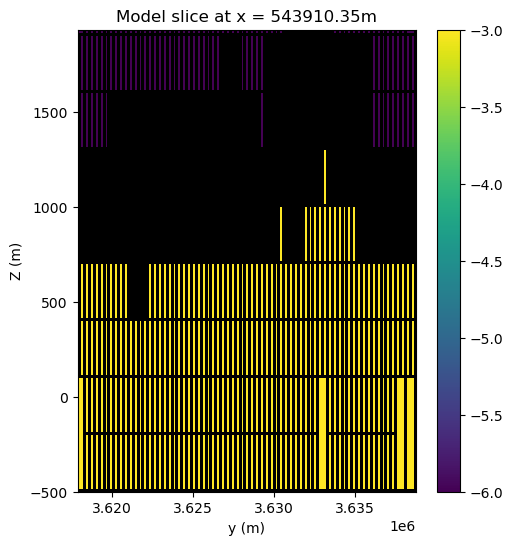

In [132]:
# Plot the model
fig = plt.figure(figsize=(12, 6))
#plot_map = maps.LogMap(mesh)*model
# Select the axis
xlim = [np.min(receiver_locations[:,0]), np.max(receiver_locations[:,0])]
ylim = [np.min(receiver_locations[:,1]), np.max(receiver_locations[:,1])]
zlim = [-500, np.max(receiver_locations[:,2])]

slice_axis = 'x'  # Change this to 'x', 'y', or 'z' as needed

# Find index of the mesh where the selected axis is approximately equal to the target value
plot_ind = np.where(getattr(mesh, f'nodes_{slice_axis}') == closest_value(mesh, x0, slice_axis))[0][0]

ax1 = fig.add_subplot(121)
out = mesh.plot_slice(np.log10(model), normal=slice_axis.upper(), ax=ax1, ind=plot_ind, grid=True)
                       #pcolor_opts={"vmin":np.log10(sig_air), "vmax":np.log10(sig_back)})
cb = plt.colorbar(out[0], orientation="vertical")

ax1.set_title(f"Model slice at {slice_axis} = {getattr(mesh, f'nodes_{slice_axis}')[int(plot_ind)]}m")

if slice_axis == 'y' or slice_axis == 'x':
    ax1.set_ylim(zlim)
    if slice_axis == 'y':
        ax1.set_xlim(xlim)
        ax1.set_xlabel('x (m)')
    else:
        ax1.set_xlim(ylim)
        ax1.set_xlabel('y (m)')
    ax1.set_ylabel('Z (m)')
else:
    ax1.set_ylim(ylim)
    ax1.set_xlim(xlim)
    plt.plot(receiver_locations[:, 0], receiver_locations[:, 1], 'r.',alpha=0.25)
    ax1.set_xlabel('x (m)')
    ax1.set_ylabel('y (m)')

In [129]:
model.min()


1e-06

In [131]:
np.log(1e-6)

-13.815510557964274

# Define survey and uncertainties
We use standard uncertainity of 0.025 for the real and 0.0125 for the imaginary components to be consistent with the values used in the GIFTools example.
In general, applying 5% relative standard deviation with a noise floor equal to 10% of max amplitude of the data is advised.

Note that the magnitude of tippers for most frequencies of ZTEM does not vary greatly. As such, an appropriate noise floor is more critical to setting the uncertainty than standard deviation. Since tipper data is sensitive only to edges of conductors, a good tell-tale sign of inappropriate uncertainties for ZTEM is a tendency for the inversion to underfit anomaly in favor of the background. 

In [36]:
frequencies = np.r_[30, 45, 90, 180, 360, 720] 

uncertainty = np.array([])
source_list = []
for freq in frequencies:
    rx_list = []
    for rx_orientation in ['zx', 'zy']:
        # get reciever locations for each frequency. 
        # Need to do this as locations may be slightly different for frequencies depending on decimation factor used. 
        receiver_locations = rx_locs(ztem_data_deci, freq)
        uncertainty = np.append(uncertainty,np.r_[0.005*np.ones_like(receiver_locations[:,0]),
                                                0.05*np.ones_like(receiver_locations[:,0])])

        # define tipper data receivers
        rx_real = nsem.receivers.Point3DTipper(receiver_locations, rx_orientation, "real")
        rx_imag = nsem.receivers.Point3DTipper(receiver_locations, rx_orientation, "imag")
        # append to the receiver list

        rx_list.append(rx_real)
        rx_list.append(rx_imag)
    # define source for each frequency
    source = nsem.sources.PlanewaveXYPrimary(rx_list, frequency=freq)
    source_list.append(source)
    
survey = nsem.Survey(source_list)

# Define the data

Data is defined as a SimPEG data object

In [ ]:
dobs = mkvc(ztem_data_deci[:,3:-1])
data_obj = data.Data(survey, dobs=dobs, standard_deviation=uncertainty)

# Define the forward simulation

In [37]:
#Using multiprocessing and splitting the simulation for each frequency on different core
mappings = []
sims = []
for src in source_list:
    mappings.append(maps.IdentityMap())
    srv_piece = nsem.Survey([src,])
    sims.append(nsem.Simulation3DPrimarySecondary(
        mesh, survey=srv_piece, sigmaMap=mapping, sigmaPrimary=halfspace, solver=Solver
    ))

sim = MultiprocessingMetaSimulation(sims, mappings)
sim.model = halfspace[active_inds]

# #If multiprocessing is unstable or undesired use below instead
# sim = nsem.Simulation3DPrimarySecondary(
#     mesh, survey=survey, solver=Solver, sigmaMap=mapping, sigmaPrimary=halfspace
# )

/home/ppokar/miniconda/envs/nsem/lib/python3.11/site-packages/SimPEG/meta/multiprocessing.py:227: UserWarning: The MetaSimulation class is a work in progress and might change in the future
  super().__init__(simulations, mappings)
/home/ppokar/miniconda/envs/nsem/lib/python3.11/site-packages/SimPEG/meta/multiprocessing.py:246: UserWarning: The MetaSimulation class is a work in progress and might change in the future
  sim_chunk = MetaSimulation(


# Plot results

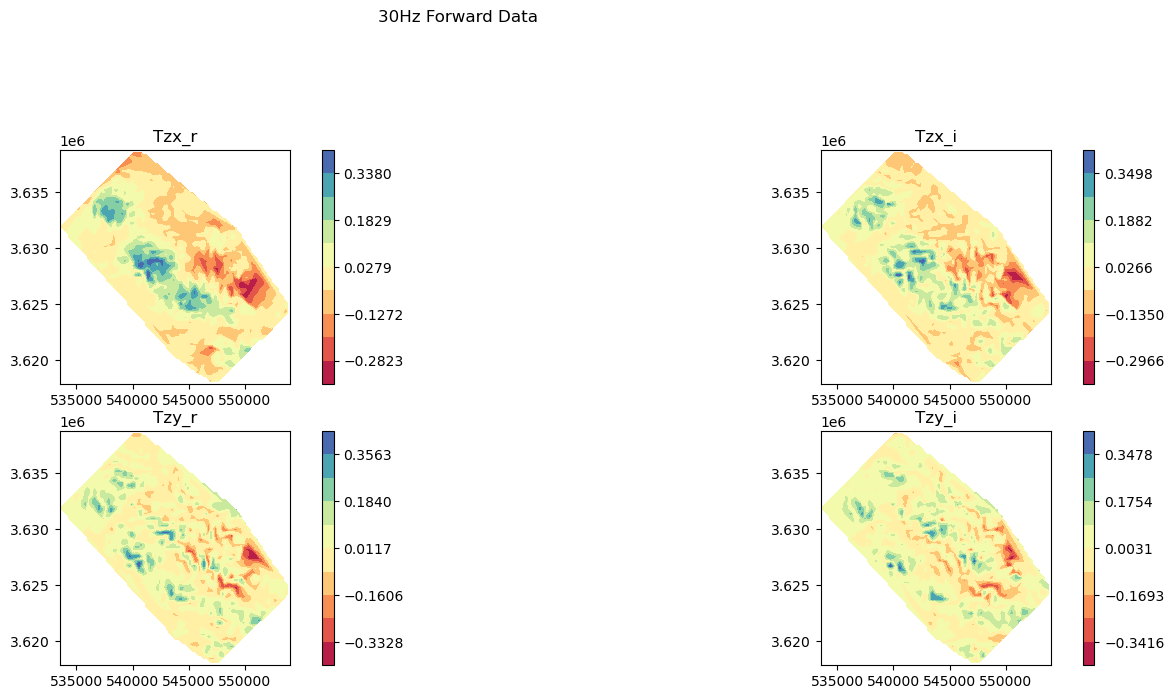

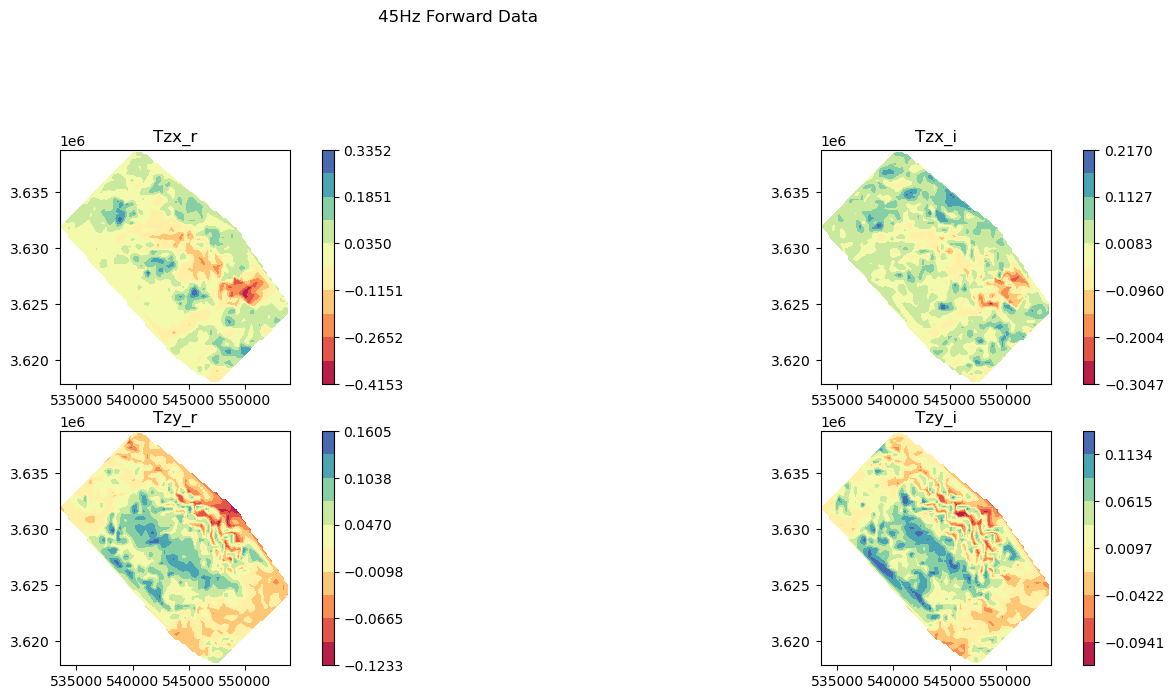

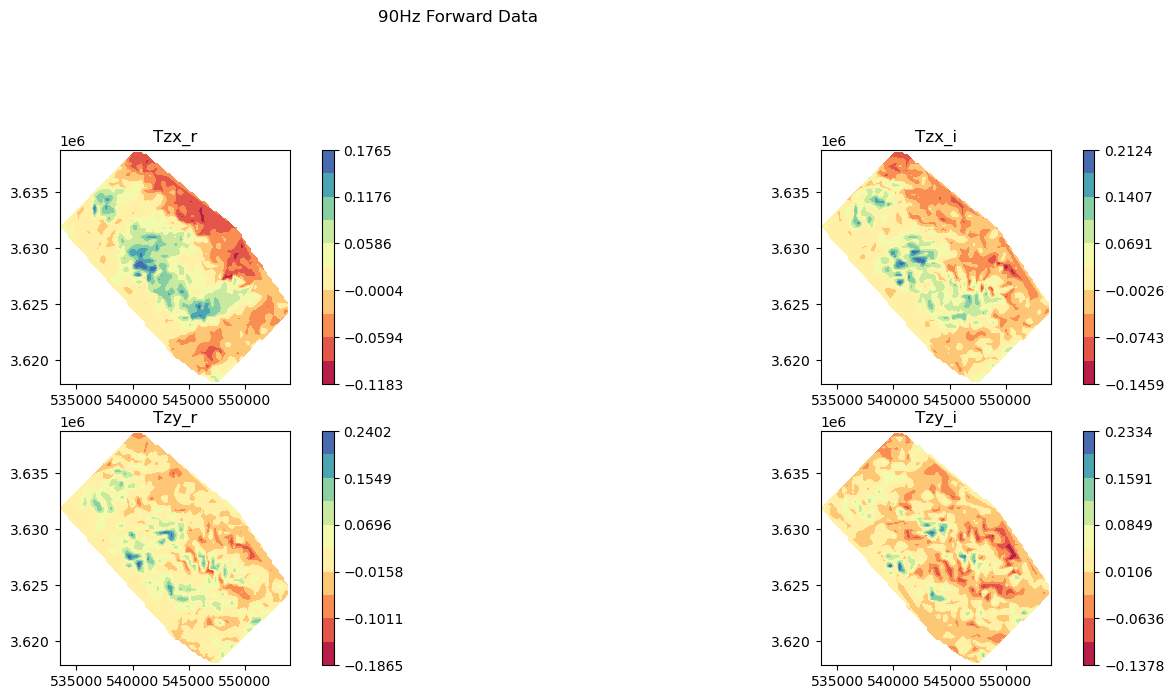

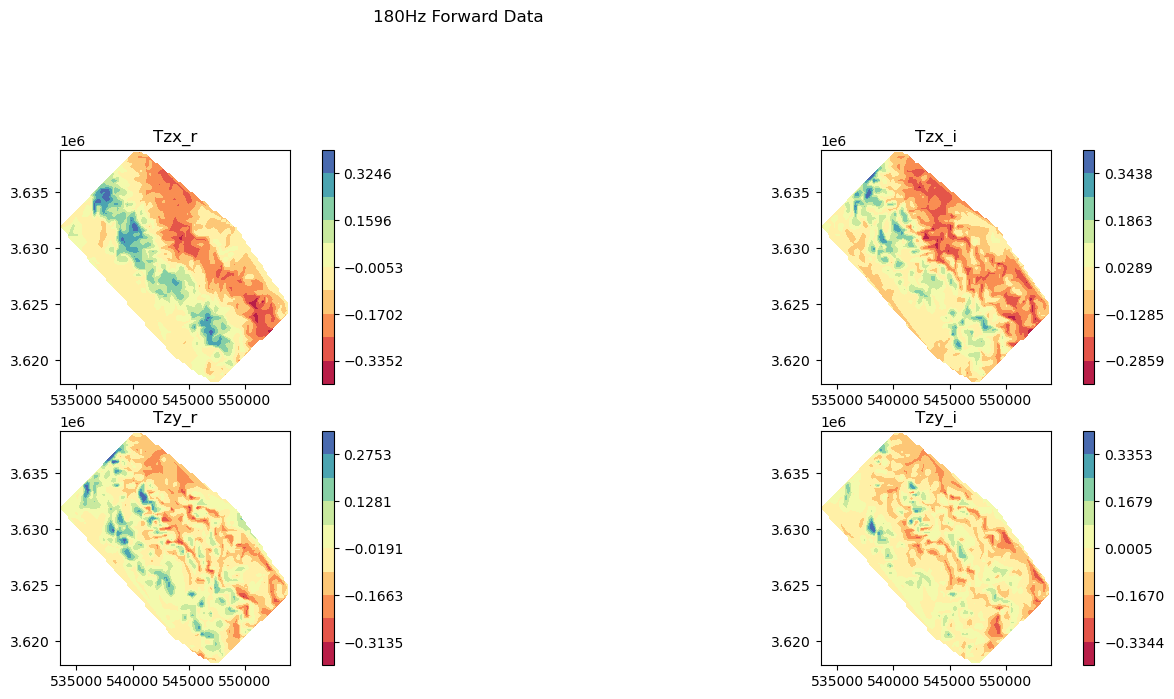

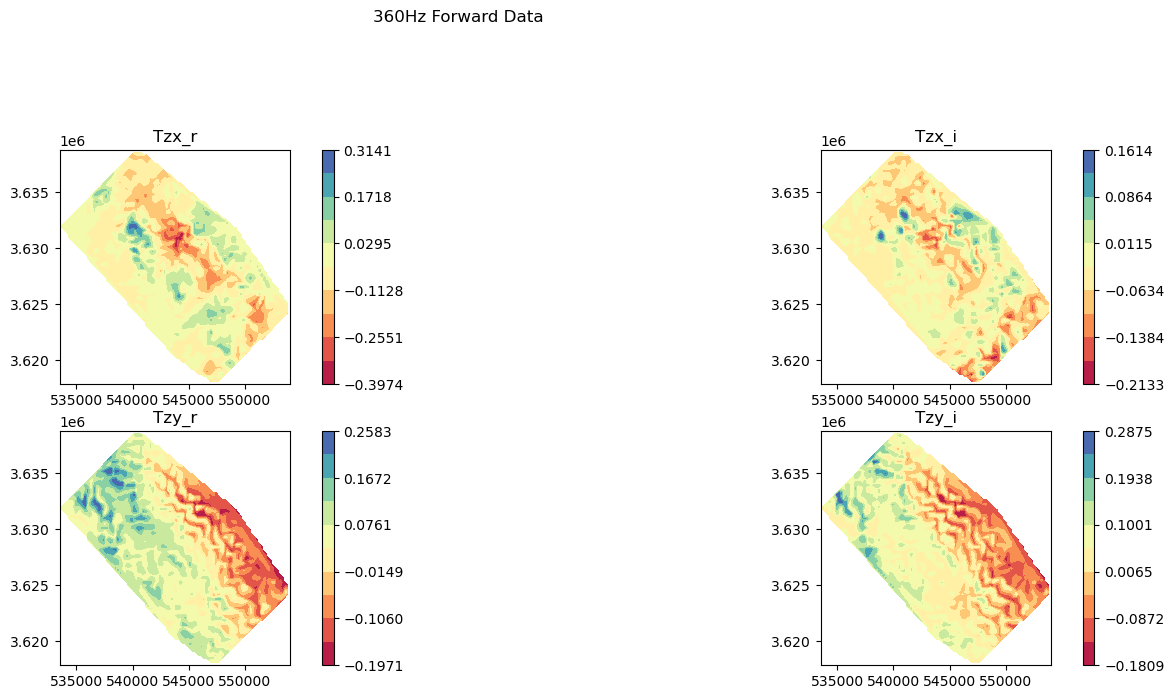

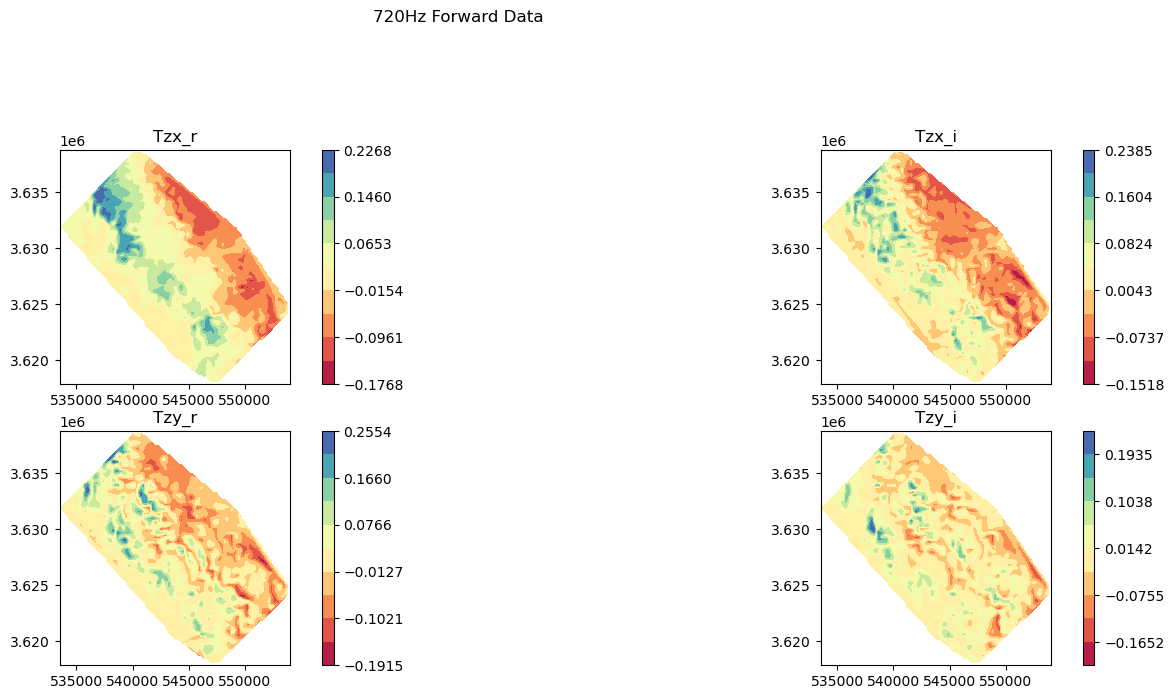

<Figure size 640x480 with 0 Axes>

In [39]:
# reshape data for plotting
num_station = receiver_locations.shape[0]
num_frequencies = len(frequencies)
#number of plots for each freq num_stations*(number of components + number of tippers). 
#here it is 36*(2+2)=144
num_sets = int(data_obj.dobs.shape[0] / len(frequencies)) 
dplot = np.reshape(data_obj.dobs, (num_frequencies, num_sets)) #rearrage data for plotting (num freqs,num sets)
stdplot = np.reshape(data_obj.standard_deviation, (num_frequencies, num_sets)) #track standard deviation for each datapoint

cnt = 0

for freq in frequencies:
    cnt_comp = 0
    comps_ = ['Tzx_r', 'Tzx_i', 'Tzy_r', 'Tzy_i']
    fig1 = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
        ax = plt.subplot(4,2, cnt_comp + 1)
        im = plot2Ddata(receiver_locations, dplot[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax, contourOpts={'cmap':'Spectral'})
        ax.set_title(comps_[rx_orientation])
        plt.colorbar(im[0])
        cnt_comp += 1
    cnt += 1
    fig1.suptitle(f"{freq}Hz Forward Data")    
plt.show()
plt.tight_layout()

# Inversion

In [41]:
#make refernce model. Here a halfspace model is used.
m_0 = np.log(halfspace[active_inds])

Set up the inversion
We use L2 data misfit and regularization. 
The reference and initial model is set as a uniform halfspace. 

For the first inversion run, $\alpha_s$ is set to a small number to get the smoothest model inversion. Target misfit is set to be equal to number of data; and a beta estimate is used with beta cooling by factor of `coolingFactor` every `coolingRate` iterations. 


In [42]:
## Setup the inversion proceedure

# Data misfit
dmis = data_misfit.L2DataMisfit(data=data_obj, simulation=sim)

# Regularization
regmap = maps.IdentityMap(nP=int(active_inds.sum()))
reg = regularization.WeightedLeastSquares(mesh, active_cells=active_inds, mapping=regmap, reference_model=m_0,
                                          alpha_x=1,alpha_y=1,alpha_z=1)
reg.alpha_s = reg.alpha_x / np.min(mesh.h[0])**2
#reg.alpha_s = 1e-4
# Optimization
opt = optimization.ProjectedGNCG(maxIter=5, upper=np.inf, lower=-np.inf, tolCG=1E-3, maxIterCG=20, )
# Inversion problem
invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)
# Beta schedule
beta_cool = directives.BetaSchedule(coolingFactor=2, coolingRate=2)
# Initial estimate of beta
beta_est = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# Target misfit stop
targmis = directives.TargetMisfit()
#targmis.target = survey.nD
saveIter = directives.SaveModelEveryIteration()
saveoutput = directives.SaveOutputEveryIteration()
# Create an inversion object
directive_list = [beta_est, beta_cool, saveIter, saveoutput, targmis]
inv = inversion.BaseInversion(invProb, directiveList=directive_list)

In [43]:
start = time.time()
# Run the inversion
mopt = inv.run(m_0)
print('Inversion took {0} minutes'.format((time.time() - start)/60))


                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
SimPEG.SaveModelEveryIteration will save your models as: './###-InversionModel-2024-04-08-18-10.npy'
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2024-04-08-18-10.txt'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.28e-04  3.57e+06  0.00e+00  3.57e+06    2.19e+04      0              
   1  5.28e-04  3.17e+06  1.94e+08  3.27e+06    1.85e+04      0              
   2  2.64e-04  2.46e+06  2.42e+08  2.52e+06    1.48e+04      0              
   3  2.64e-04  2.28e+06  2.56e+08  2.35e+06    1.45e+04      0              
   4 

# Plot results

In [134]:
# Plot recovered model
plot_map = maps.ExpMap(mesh) * actMap
mopt_rec = plot_map * mopt
fig = plt.figure(figsize=(12, 6))
# Select the axis
xlim = [np.min(receiver_locations[:,0]), np.max(receiver_locations[:,0])]
ylim = [np.min(receiver_locations[:,1]), np.max(receiver_locations[:,1])]
zlim = [-500, np.max(receiver_locations[:,2])]

slice_axis = 'y'  # Change this to 'x', 'y', or 'z' as needed

# Find index of the mesh where the selected axis is approximately equal to the target value
plot_ind = np.where(getattr(mesh, f'nodes_{slice_axis}') == closest_value(mesh, y0, slice_axis))[0][0]

ax1 = fig.add_subplot(121)
out = mesh.plot_slice(np.log10(mopt_rec), normal=slice_axis.upper(), ax=ax1, ind=plot_ind, grid=False,
                       pcolor_opts={"vmin":np.log10(sig_air), "vmax":np.log10(10)})
cb = plt.colorbar(out[0], orientation="vertical")

ax1.set_title(f"Model slice at {slice_axis} = {getattr(mesh, f'nodes_{slice_axis}')[int(plot_ind)]}m")

if slice_axis == 'y' or slice_axis == 'x':
    ax1.set_ylim(zlim)
    if slice_axis == 'y':
        ax1.set_xlim(xlim)
        ax1.set_xlabel('x (m)')
    else:
        ax1.set_xlim(ylim)
        ax1.set_xlabel('y (m)')
    ax1.set_ylabel('Z (m)')
else:
    #ax1.set_ylim(ylim)
    #ax1.set_xlim(xlim)
    plt.plot(receiver_locations[:, 0], receiver_locations[:, 1], 'r.',alpha=0.25)
    ax1.set_xlabel('x (m)')
    ax1.set_ylabel('y (m)')

ValueError: Dimension mismatch in ComboMap[ExpMap(144502,144502) * InjectActiveCells(144502,66356)](144502,66356) and np.ndarray(66536,).

In [133]:
mopt_rec

array([1.e-08, 1.e-08, 1.e-08, ..., 1.e-08, 1.e-08, 1.e-08])

In [ ]:
# Predict fields and data for a synthetic model

drec = invProb.dpred
drec_obj = data.Data(survey, dobs=drec)

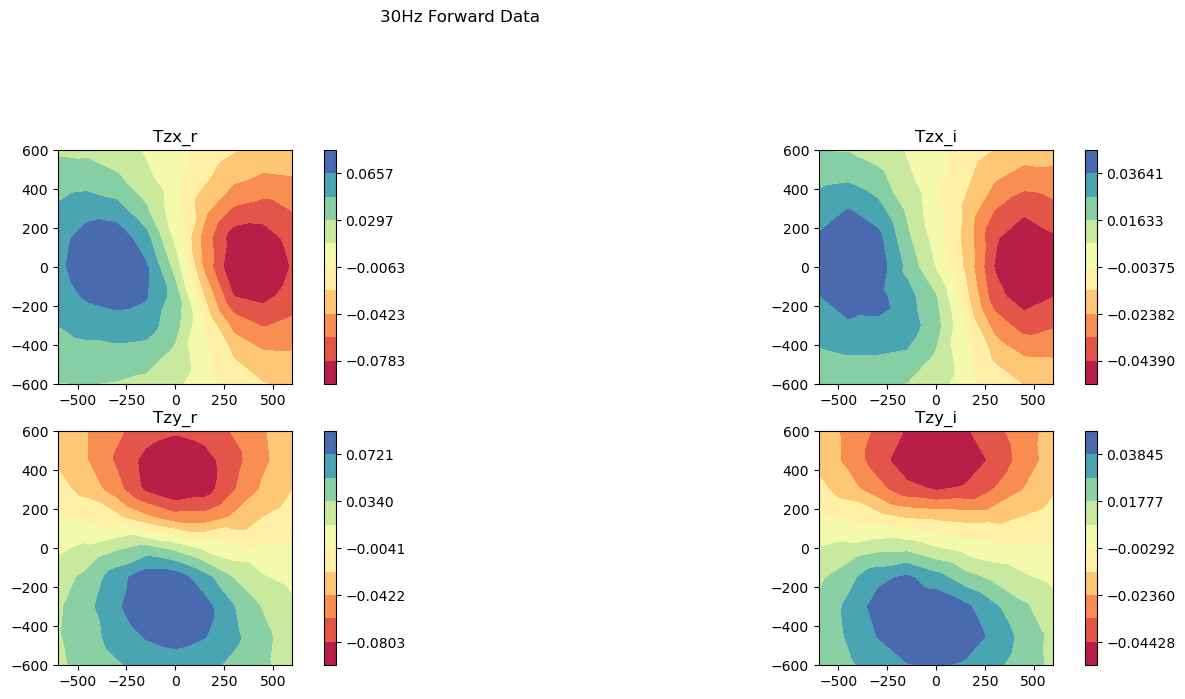

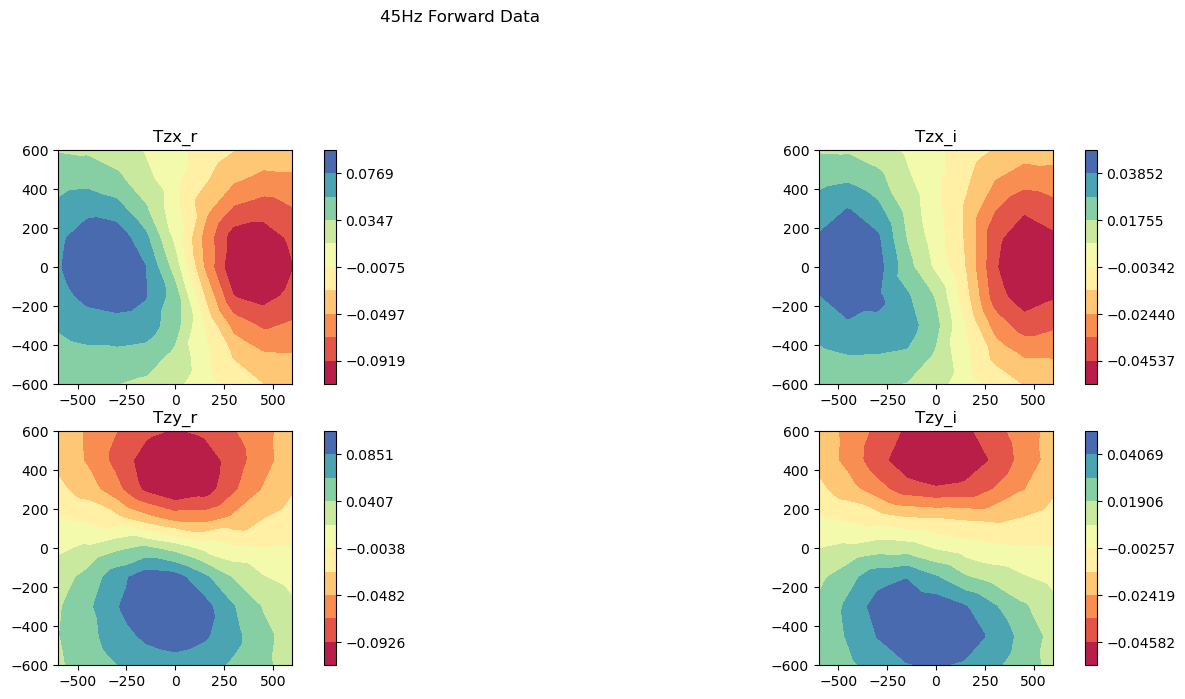

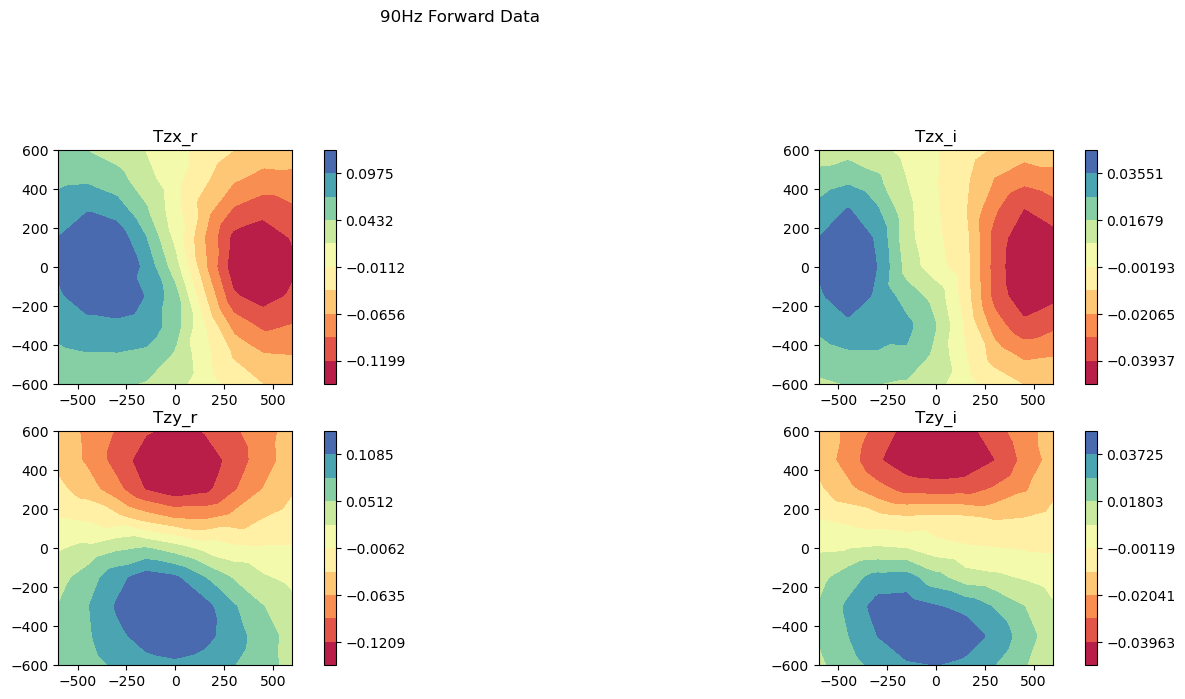

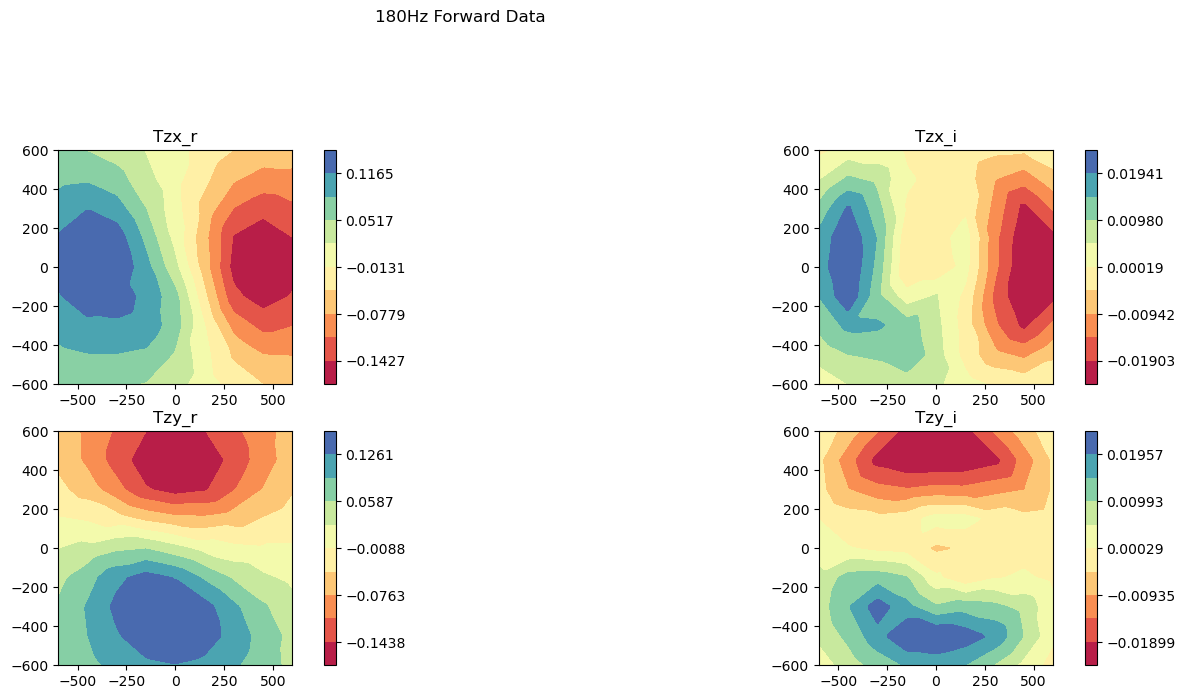

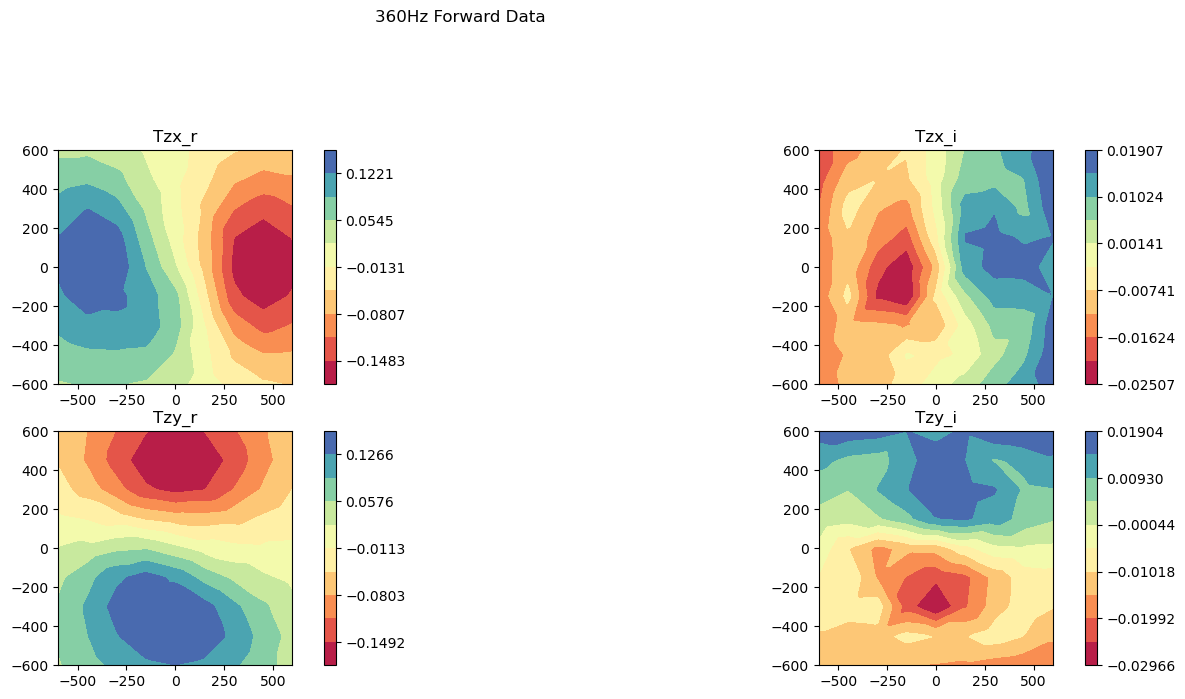

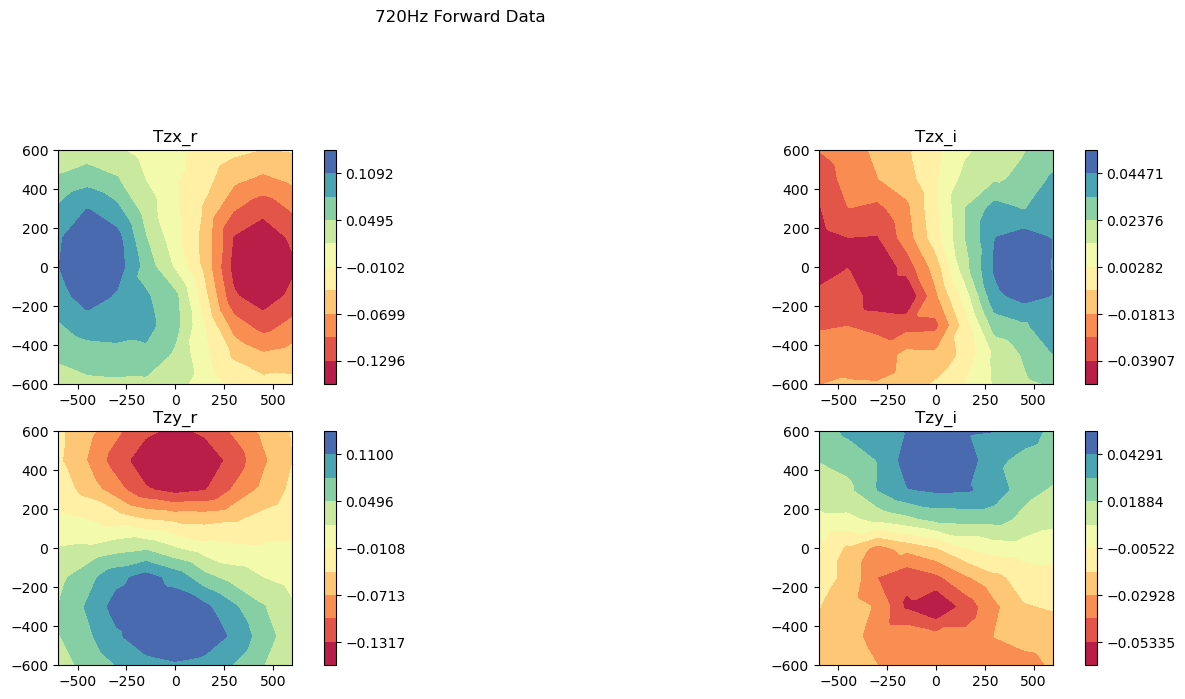

<Figure size 640x480 with 0 Axes>

In [ ]:
# reshape data for plotting
num_station = receiver_locations.shape[0]
num_frequencies = len(frequencies)
#number of plots for each freq num_stations*(number of components + number of tippers). 
#here it is 36*(2+2)=144
num_sets = int(drec_obj.dobs.shape[0] / len(frequencies)) 
dplot = np.reshape(drec_obj.dobs, (num_frequencies, num_sets)) #rearrage data for plotting (num freqs,num sets)

cnt = 0

for freq in frequencies:
    cnt_comp = 0
    comps_ = ['Tzx_r', 'Tzx_i', 'Tzy_r', 'Tzy_i']
    fig1 = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
        ax = plt.subplot(4,2, cnt_comp + 1)
        im = plot2Ddata(receiver_locations, dplot[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax, contourOpts={'cmap':'Spectral'})
        ax.set_title(comps_[rx_orientation])
        plt.colorbar(im[0])
        cnt_comp += 1
    cnt += 1
    fig1.suptitle(f"{freq}Hz Forward Data")    
plt.show()
plt.tight_layout()